[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FurkanAI/Photovoltaic-Panel-Parameters-Estimation-with-MBBPSO_SA/blob/master/PV_Model_Parameter_Estimation_and_Result.ipynb)

## Libraries

In [ ]:
# ==============================================================================
#           INSTALL REQUIRED LIBRARIES (Run this cell once)
# ==============================================================================
# This section ensures that all necessary Python libraries are installed.
# It is recommended to run this cell at the beginning of your session,
# especially in environments like Google Colab or when setting up a new environment.
# ==============================================================================

import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to install {package}: {e}")

# List of required packages
required_packages = [
    "numpy>=1.24.0",    # Or your specific tested version e.g. "numpy==1.24.0"
    "pandas>=1.5.0",    # Or your specific tested version
    "scipy>=1.9.0",     # Or your specific tested version
    "matplotlib>=3.6.0",# Or your specific tested version
    "ipykernel"         # For Jupyter Notebook functionality
]

for package in required_packages:
    install_package(package)


In [1]:
# ==============================================================================
#           IMPORT LIBRARIES
# ==============================================================================
# Ensure all necessary libraries are imported before running the main code.
# ==============================================================================

import math
import time
from typing import Literal
from functools import partial 
from datetime import timedelta 
import ast

import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
# Clear warnings for cleaner output (optional, depends on your preference)
import warnings
warnings.filterwarnings("ignore")

## Settings

In [2]:
# ==============================================================================
#                 ADJUSTABLE ALGORITHM PARAMETERS
# ==============================================================================
# This section defines key parameters that control the behavior of various
# optimization algorithms. You can modify these values to influence the
# algorithms' performance and search strategies.
# ==============================================================================

# repetitions: The number of times each algorithm will be run on a given problem.
#              This ensures statistically more reliable results (used for averaging).
repetitions = 5

# seed_generator_seed: Main seed for generating repetitions' unique seeds.
# This value acts as the master seed for the random number generator that produces
# individual seeds for each repetition.
#
# - If a fixed integer value (e.g., 73) is provided:
#   The same sequence of individual repetition seeds will be generated every time
#   the code runs. This ensures that if you run the experiment multiple times,
#   each repetition will start with the exact same initial "randomness",
#   making your results reproducible across runs.
#
# - If set to None:
#   The master seed will be truly random (e.g., based on system time).
#   Consequently, the individual seeds generated for each repetition will be
#   different every time you run the code. This leads to varying results
#   across different executions, as each run will explore different random paths.
seed_generator_seed = None

# General Optimization Parameters
# ------------------------------------------------------------------------------
# iter: The maximum number of iterations for each algorithm run.
#       This determines how long the optimization process will last.
iter = 300

# Swarm-Based Optimization (PSO, BBPSO, MBBPSO, PSO_SA, Dynamic PSO)
# and Differential Evolution (DE) Parameters
# ------------------------------------------------------------------------------
# nop: "Number of Particles" or "Population Size."
#      Defines the number of individuals/particles working simultaneously in the
#      search space for swarm/population-based algorithms. Higher values often
#      offer better solution potential but increase computational cost.
nop = 20

# Simulated Annealing (SA) and PSO-Simulated Annealing (PSO_SA) Parameters
# ------------------------------------------------------------------------------
# T: Initial temperature. Controls the algorithm's probability of accepting
#    worse solutions at the beginning. A higher initial temperature encourages
#    broader exploration of the search space.
T = 100

# alpha: Cooling rate. Determines how much the temperature decreases in each iteration.
#        Typically ranges between 0.85 and 0.99. A lower alpha means faster
#        cooling and potentially earlier convergence.
alpha = 0.98

# Differential Evolution (DE) Algorithm Parameters
# ------------------------------------------------------------------------------
# F: Differential weight factor (Scaling Factor). Controls how much the vector
#    difference is scaled when creating new individuals. Usually between 0.5 and 1.0.
F = 0.5

# CR: Crossover Rate. Determines how often an individual inherits genes (parameters)
#     from its parents. A value between 0 and 1. A higher CR leads to more variation.
CR = 0.2

# Dynamic PSO Parameters
# ------------------------------------------------------------------------------
# w_start: Starting value for the inertia weight (w).
#          Controls how much particles focus on global search. Higher values
#          emphasize exploration.
w_start = 0.9

# w_end: Ending value for the inertia weight (w).
#        As the algorithm progresses, the weight gradually decreases from w_start to w_end.
#        Lower values emphasize local search (exploitation).
w_end = 0.4

# Common Particle Swarm Optimization Parameters (for PSO_SA, PSO, Dynamic PSO)
# ------------------------------------------------------------------------------
# w: Inertia Weight. Determines the influence of a particle's current velocity
#    on its next velocity. A higher 'w' promotes exploration, while a lower 'w'
#    facilitates exploitation/convergence.
w = 0.5

# c1: Cognitive Coefficient or Individual Learning Factor.
#     Controls how much a particle is attracted to its own best-found position.
#     Higher values enhance individual search capability.
c1 = 1.5

# c2: Social Coefficient or Global Learning Factor.
#     Controls how much a particle is attracted to the swarm's overall best-found position.
#     Higher values increase cooperation within the swarm and promote global convergence.
c2 = 1.5


# ==============================================================================
#                 PV MODEL AND OPTIMIZATION CONFIGURATION
# ==============================================================================
# This section contains the core parameters for setting up your PV panel
# modeling and optimization process. These values define the specific diode
# model to be used, panel characteristics, data input, and optimization bounds.
# ==============================================================================


# Record Path (Optional)
# If results or process information are to be saved to a file, assign the file path here.
# The path MUST include a '.csv' extension (e.g., 'my_results.csv').
# IMPORTANT: If 'None' (as set), NO recording will be performed. The results will NOT be saved to any file.
# If a string path is provided (e.g., 'my_results.csv'), the results will be saved to that specific file.
record_path = None

# Diode Model Type Selection
# Users select the diode model for PV panel characterization here.
# 1 => Single Diode Model (SDM): A common and simpler model.
# 2 => Double Diode Model (DDM): Includes a second diode for improved accuracy.
# 3 => Triple Diode Model (TDM): Used for situations requiring very high accuracy.
# If an invalid number or any other input is provided, the Single Diode Model (SDM) will be used by default.
diode_model_type = 3

# Panel Characteristics
# Ns: Number of series-connected cells in the panel. Directly influences voltage characteristics.
Ns = 36

# Vth: Thermal voltage at 25°C. A key parameter in the diode's current-voltage relationship.
# It's calculated as: Vth = (k * T) / q
# where:
# k = Boltzmann's constant (1.380649 × 10^-23 J/K)
# T = Absolute temperature in Kelvin (e.g., 25°C = 298.15 K)
# q = Elementary charge (electron charge) (1.602176634 × 10^-19 C)
Vth = 0.02585

# Measured Data
# measured_voltage_array: NumPy array containing measured voltage values from the PV panel.
# measured_current_array: NumPy array containing measured current values from the PV panel.
# Users can input their own measurement data here to calculate panel parameters
# (e.g., Iph, Rs, Rsh, etc.) based on the selected diode model.
measured_voltage_array = None
measured_current_array = None

# Model Parameter Bounds
# parameters_bounds: A NumPy array defining the lower and upper limits for each diode model parameter.
# These bounds ensure that parameters remain within realistic ranges during the optimization process.
# Parameters and Their Descriptions:
# Iph (Photocurrent): Current generated due to solar irradiance.
# Rs (Series Resistance): Resistance from internal series connections within the panel.
# Rsh (Shunt Resistance): Parallel resistance representing leakage currents within the panel.
# n1, n2, n3 (Diode Ideality Factors): Indicate deviation of diodes from ideal behavior.
# Io1, Io2, Io3 (Saturation Currents): Reverse saturation currents of the diodes.
parameters_bounds = np.array([
# Low Limit | High Limit
    [4.5,           5.5],       # Iph (Photocurrent)
    [0.0,           0.5],       # Rs (Series Resistance)
    [1e-9,        500.0],       # Rsh (Shunt Resistance)
    [1.0,           2.0],       # n1 (1st Diode Ideality Factor)
    [1e-9,        10e-6],       # Io1 (1st Diode Saturation Current)
    [1.2,           2.0],       # n2 (2nd Diode Ideality Factor - Only for DDM and TDM)
    [1e-9,        10e-6],       # Io2 (2nd Diode Saturation Current - Only for DDM and TDM)
    [1.4,           2.0],       # n3 (3rd Diyot Ideality Factor - Only for TDM)
    [1e-9,        10e-6]        # Io3 (3rd Diode Saturation Current - Only for TDM)
])


## Metaheuristic Algorithms

In [3]:
def MBBPSO(func, dim, bounds, reps=1, nop=100, iter=500, seed=None):

    rng = np.random.default_rng(seed)
    llim = bounds[:, 0]
    ulim = bounds[:, 1]

    feval = np.empty(reps)
    tElapsed = np.empty(reps)
    best_params = np.empty((reps, dim))
    fgbest_arr = np.empty(iter)
    
    for ri in range(reps):
        x = rng.uniform(llim, ulim, (nop, dim))
        f = np.array([func(xi) for xi in x])

        pBest = x.copy()
        fp = f.copy()

        fg = np.min(f)
        gBest = x[np.argmin(f)]
        pindx = 1

        start_time = time.perf_counter()

        for i in range(iter):
            if pindx < 2:
                d = rng.normal(0, 1, (nop, dim)) * np.abs(x - gBest)
                x = 0.5 * (x + gBest) + d
                pindx += 1
            else:
                d = rng.uniform(-1, 1, (nop, dim)) * np.abs(x - gBest)
                x = pBest + d
                pindx = 1

            x = np.clip(x, llim, ulim)
            f = np.array([func(xi) for xi in x])
          
            mask = f < fp
            fp[mask] = f[mask]
            pBest[mask] = x[mask]

            
            min_f = np.min(fp)
            if min_f < fg:
                fg = min_f
                gBest = x[np.argmin(fp)]

            fgbest_arr[i] = fg
            
        tElapsed[ri] = time.perf_counter() - start_time
        feval[ri] = fg
        best_params[ri] = gBest

    return feval, tElapsed, best_params, fgbest_arr

########################################################################################################

def MBBPSO_SA(func, dim, bounds, reps=1, nop=100, iter=500, T=10, alpha=0.95, seed=None):

    rng = np.random.default_rng(seed)
    llim = bounds[:, 0]
    ulim = bounds[:, 1]

    feval = np.empty(reps)
    tElapsed = np.empty(reps)
    best_params = np.empty((reps, dim))
    fgbest_arr = np.empty(iter)
    
    for ri in range(reps):
        x = rng.uniform(llim, ulim, (nop, dim))
        f = np.array([func(xi) for xi in x])

        pBest = x.copy()
        fp = f.copy()

        fg = np.min(f)
        gBest = x[np.argmin(f)]
        pindx = 1

        start_time = time.perf_counter()

        for i in range(iter):
            if pindx < 2:
                d = rng.normal(0, 1, (nop, dim)) * np.abs(x - gBest)
                x_c = 0.5 * (x + gBest) + d
                pindx += 1
            else:
                d = rng.uniform(-1, 1, (nop, dim)) * np.abs(x - gBest)
                x_c = pBest + d
                pindx = 1

            x_c = np.clip(x_c, llim, ulim)
            f_c = np.array([func(xi) for xi in x_c])
            
            mask = f_c <= f
            f[mask] = f_c[mask]
            x[mask] = x_c[mask]
            
            delta = f_c[~mask] - f[~mask]
            prob = np.exp(-delta / T)
            accept = rng.random(len(delta)) < prob
            
            f[~mask][accept] = f_c[~mask][accept]
            x[~mask][accept] = x_c[~mask][accept]
            
            mask = f < fp
            fp[mask] = f[mask]
            pBest[mask] = x[mask]

            min_f = np.min(fp)
            if min_f < fg:
                fg = min_f
                gBest = x[np.argmin(fp)]

            fgbest_arr[i] = fg
            T *= alpha

        tElapsed[ri] = time.perf_counter() - start_time
        feval[ri] = fg
        best_params[ri] = gBest

    return feval, tElapsed, best_params, fgbest_arr 

########################################################################################################

def SA(func, dim, bounds, reps=1, iter=500, T=1000, alpha=0.95, seed=None):

    rng = np.random.default_rng(seed)
    llim = bounds[:, 0]
    ulim = bounds[:, 1]

    feval = np.empty(reps)
    tElapsed = np.empty(reps)
    best_params = np.empty((reps, dim))
    fgbest_arr = np.empty(iter)
    
    for ri in range(reps):
        # Başlangıç çözümü
        current_solution = rng.uniform(llim, ulim)
        current_value = func(current_solution)

        # En iyi çözüm başlangıçta
        best_solution = current_solution.copy()
        best_value = current_value

        start_time = time.perf_counter()

        for _ in range(iter):
            
            neighbor = current_solution + rng.normal(0, (ulim - llim) * 0.1, dim)
            neighbor = np.clip(neighbor, llim, ulim)

            f_neighbor = func(neighbor)
            delta = f_neighbor - current_value
       
            if delta < 0 or rng.random() < np.exp(-delta / (T + 1e-8)):
                current_solution = neighbor
                current_value = f_neighbor
   
                if current_value < best_value:
                    best_solution = current_solution.copy()
                    best_value = current_value
            
            fgbest_arr[i] = best_value
            T *= alpha

        tElapsed[ri] = time.perf_counter() - start_time
        feval[ri] = best_value
        best_params[ri] = best_solution

    return feval, tElapsed, best_params, fgbest_arr

########################################################################################################

def PSO_SA(func, dim, bounds, reps=1, nop=30, iter=500, T=1000, alpha=0.95, w=0.5, c1=1.5, c2=1.5, seed=None):

    rng = np.random.default_rng(seed)
    llim = bounds[:, 0]
    ulim = bounds[:, 1]

    feval = np.empty(reps)
    tElapsed = np.empty(reps)
    best_params = np.empty((reps, dim))
    fgbest_arr = np.empty(iter)
    
    for ri in range(reps):

        x = rng.uniform(llim, ulim, (nop, dim))
        v = rng.uniform(-np.abs(ulim - llim), np.abs(ulim - llim), (nop, dim))
        f = np.array([func(xi) for xi in x])

        pBest = x.copy()
        fp = f.copy()

        fg = np.min(f)
        gBest = x[np.argmin(f)]

        start_time = time.perf_counter()

        for i in range(iter):
            r1 = rng.random((nop, dim))
            r2 = rng.random((nop, dim))

            v = (w * v) + c1 * r1 * (pBest - x) + c2 * r2 * (gBest - x)

            x_c = x + v
            x_c = np.clip(x_c, llim, ulim)
            f_c = np.array([func(xi) for xi in x_c])

            mask = f_c <= f
            f[mask] = f_c[mask]
            x[mask] = x_c[mask]
            
            delta = f_c[~mask] - f[~mask]
            prob = np.exp(-delta / T)
            accept = rng.random(len(delta)) < prob
            
            f[~mask][accept] = f_c[~mask][accept]
            x[~mask][accept] = x_c[~mask][accept]
            
            mask = f < fp
            fp[mask] = f[mask]
            pBest[mask] = x[mask]

            min_f = np.min(fp)
            if min_f < fg:
                fg = min_f
                gBest = x[np.argmin(fp)]

            fgbest_arr[i] = fg
            T *= alpha

        tElapsed[ri] = time.perf_counter() - start_time
        feval[ri] = fg
        best_params[ri] = gBest

    return feval, tElapsed, best_params, fgbest_arr

########################################################################################################

def BBPSO(func, dim, bounds, reps=1, nop=30, iter=500, seed=None):
    rng = np.random.default_rng(seed)
    llim = bounds[:, 0]
    ulim = bounds[:, 1]

    feval = np.empty(reps)
    tElapsed = np.empty(reps)
    best_params = np.empty((reps, dim))
    fgbest_arr = np.empty(iter)
    
    for ri in range(reps):

        x = rng.uniform(llim, ulim, (nop, dim))
        f = np.array([func(ind) for ind in x])

        pBest = x.copy()
        fp = f.copy()

        fg = np.min(fp)
        gBest = x[np.argmin(fp)]

        start_time = time.perf_counter()

        for i in range(iter):

            mean = (pBest + gBest) / 2
            std = np.abs(pBest - gBest)
            x_c = rng.normal(loc=mean, scale=std)

            x_c = np.clip(x_c, llim, ulim)

            f_c = np.array([func(ind) for ind in x_c])

            improved = f_c < fp
            pBest[improved] = x_c[improved]
            fp[improved] = f_c[improved]

            best_idx = np.argmin(fp)
            if fp[best_idx] < fg:
                fg = fp[best_idx]
                gBest = pBest[best_idx].copy()

            fgbest_arr[i] = fg

        tElapsed[ri] = time.perf_counter() - start_time
        feval[ri] = fg
        best_params[ri] = gBest

    return feval, tElapsed, best_params, fgbest_arr

########################################################################################################

def DE(func, dim, bounds, reps=1, nop=25, iter=500, F=0.5, CR=0.2, seed=None):
    rng = np.random.default_rng(seed)
    llim = bounds[:, 0]
    ulim = bounds[:, 1]

    feval = np.empty(reps)
    tElapsed = np.empty(reps)
    best_params = np.empty((reps, dim))
    fgbest_arr = np.empty(iter)
    
    for ri in range(reps):

        population = rng.uniform(llim, ulim, (nop, dim))
        fitness = np.array([func(ind) for ind in population])

        best_idx = np.argmin(fitness)
        best_sol = population[best_idx].copy()
        best_fit = fitness[best_idx]

        start_time = time.perf_counter()

        for j in range(iter):
            for i in range(nop):
                
                indices = [idx for idx in range(nop) if idx != i]
                a, b, c = rng.choice(indices, size=3, replace=False)
                mutant = population[a] + F * (population[b] - population[c])
                mutant = np.clip(mutant, llim, ulim)

                trial = population[i].copy()
                rand_j = rng.integers(0, dim)
                for j in range(dim):
                    if rng.random() < CR or j == rand_j:
                        trial[j] = mutant[j]

                trial_fit = func(trial)
                if trial_fit <= fitness[i]:
                    population[i] = trial
                    fitness[i] = trial_fit
                    if trial_fit < best_fit:
                        best_sol = trial.copy()
                        best_fit = trial_fit

            fgbest_arr[j] = best_fit
                
        tElapsed[ri] = time.perf_counter() - start_time
        feval[ri] = best_fit
        best_params[ri] = best_sol

    return feval, tElapsed, best_params, fgbest_arr

########################################################################################################

def PSO(func, dim, bounds, reps=1, nop=30, iter=500, w_start=0.9, w_end=0.4, c1=2.0, c2=2.0, dynamic_omega=True, seed=None):
    rng = np.random.default_rng(seed)
    llim = bounds[:, 0]
    ulim = bounds[:, 1]
    w = w_start
    
    feval = np.empty(reps)
    tElapsed = np.empty(reps)
    best_params = np.empty((reps, dim))
    fgbest_arr = np.empty(iter)
    
    for ri in range(reps):

        x = rng.uniform(llim, ulim, (nop, dim))
        v = rng.uniform(-0.1 * (ulim - llim), 0.1 * (ulim - llim), (nop, dim))
        f = np.array([func(ind) for ind in x])

        pBest = x.copy()
        fp = f.copy()

        fg = np.min(fp)
        gBest = x[np.argmin(fp)]

        start_time = time.perf_counter()
        
        for i in range(iter):
            
            if dynamic_omega:
                w = w_start - (w_start - w_end) * (i / iter)

            r1 = rng.random((nop, dim))
            r2 = rng.random((nop, dim))

            v = (w * v) + c1 * r1 * (pBest - x) + c2 * r2 * (gBest - x)
            x_c = x + v
            x_c = np.clip(x_c, llim, ulim)

            f_c = np.array([func(ind) for ind in x_c])

            improved = f_c < fp
            pBest[improved] = x_c[improved]
            fp[improved] = f_c[improved]

            best_idx = np.argmin(fp)
            if fp[best_idx] < fg:
                fg = fp[best_idx]
                gBest = pBest[best_idx].copy()
            
            x = x_c
            fgbest_arr[i] = fg
            
        tElapsed[ri] = time.perf_counter() - start_time
        feval[ri] = fg
        best_params[ri] = gBest

    return feval, tElapsed, best_params, fgbest_arr


## Functions

In [4]:
def f_single(i, v, p, nNsVth):
    Iph, Rs, Rsh, n, Io = p
    return Iph - Io * (np.exp((v + i * Rs) / nNsVth) - 1) - (v + i * Rs) / Rsh - i

#####################################################################################################

def f_double(i, v, p, nNsVth1, nNsVth2):
    Iph, Rs, Rsh, n1, Io1, n2, Io2 = p
    return Iph - Io1 * (np.exp((v + i * Rs) / nNsVth1) - 1) - Io2 * (np.exp((v + i * Rs) / nNsVth2) - 1) - (v + i * Rs) / Rsh - i

#####################################################################################################

def f_triple(i, v, p, nNsVth1, nNsVth2, nNsVth3):
    Iph, Rs, Rsh, n1, Io1, n2, Io2, n3, Io3 = p
    return Iph - Io1 * (np.exp((v + i * Rs) / nNsVth1) - 1) - Io2 * (np.exp((v + i * Rs) / nNsVth2) - 1) - Io3 * (np.exp((v + i * Rs) / nNsVth3) - 1) - (v + i * Rs) / Rsh - i

#####################################################################################################

def objective_single(
    params: np.ndarray,
    V_real: np.ndarray,
    I_real: np.ndarray,
    Ns: int = 36,
    Vth: float = 0.02585,
    Iph_max: float | None = None
) -> float:
    
    """
    Objective function that returns the RMSE by comparing the accuracy of the given parameters
    for the single diode PV model with real I-V data.

    Args:
        params (np.ndarray): Model parameters [Iph, Rs, Rsh, n, Io]
        V_real (np.ndarray): Real voltage data (V)
        I_real (np.ndarray): Real current data (I)
        Ns (int): Number of series-connected cells (default 36)
        Vth (float): Thermal voltage (default 0.02585 V)
        Iph_max (float | None): Upper current limit for the Brentq solution (default: Iph)

    Returns:
        float: RMSE (error) between real and estimated I values
    """
    
    I_model = np.zeros_like(V_real)
    Iph_bound = Iph_max or params[0]
    nNsVth = params[3] * Ns * Vth

    for idx, v in enumerate(V_real):
        try:
            sol = root_scalar(f_single, args=(v, params, nNsVth),
                              bracket=[0, Iph_bound], method='brentq')
            I_model[idx] = sol.root
        except (ValueError, RuntimeError):
            I_model[idx] = 0.0

    return np.sqrt(np.mean((I_real - I_model) ** 2))

#####################################################################################################

def objective_double(
    params: np.ndarray,
    V_real: np.ndarray,
    I_real: np.ndarray,
    Ns: int = 36,
    Vth: float = 0.02585,
    Iph_max: float | None = None
) -> float:
    
    """
    Objective function that calculates I_model based on the given parameters
    for the double diode PV model and returns the RMSE.

    Args:
        params (np.ndarray): Model parameters [Iph, Rs, Rsh, n1, Io1, n2, Io2]
        V_real (np.ndarray): Real voltage data (V)
        I_real (np.ndarray): Real current data (I)
        Ns (int): Number of series-connected cells (default 36)
        Vth (float): Thermal voltage (default 0.02585 V)
        Iph_max (float | None): Upper current limit for Brentq (default: Iph)

    Returns:
        float: RMSE value between the real and model current
    """
    
    I_model = np.zeros_like(V_real)
    Iph_bound = Iph_max or params[0]
    nNsVth1 = params[3] * Ns * Vth
    nNsVth2 = params[5] * Ns * Vth

    for idx, v in enumerate(V_real):
        try:
            sol = root_scalar(f_double, args=(v, params, nNsVth1, nNsVth2),
                              bracket=[0, Iph_bound], method='brentq')
            I_model[idx] = sol.root
        except (ValueError, RuntimeError):
            I_model[idx] = 0.0

    return np.sqrt(np.mean((I_real - I_model) ** 2))

#####################################################################################################

def objective_triple(
    params: np.ndarray,
    V_real: np.ndarray,
    I_real: np.ndarray,
    Ns: int = 36,
    Vth: float = 0.02585,
    Iph_max: float | None = None
) -> float:
    
    """
    Objective function that calculates the accuracy of parameters for the triple diode PV model
    and returns the Root Mean Square Error (RMSE) based on real data.

    Args:
        params (np.ndarray): Model parameters [Iph, Rs, Rsh, n1, Io1, n2, Io2, n3, Io3]
        V_real (np.ndarray): Real voltage data (V)
        I_real (np.ndarray): Real current data (I)
        Ns (int): Number of series-connected cells (default 36)
        Vth (float): Thermal voltage (default 0.02585 V)
        Iph_max (float | None): Upper current limit for root-finding (default: Iph)

    Returns:
        float: RMSE (error between real current and model current)
    """
    
    I_model = np.zeros_like(V_real)
    Iph_bound = Iph_max or params[0]
    nNsVth1 = params[3] * Ns * Vth
    nNsVth2 = params[5] * Ns * Vth
    nNsVth3 = params[7] * Ns * Vth

    for idx, v in enumerate(V_real):
        try:
            sol = root_scalar(f_triple, args=(v, params, nNsVth1, nNsVth2, nNsVth3),
                              bracket=[0, Iph_bound], method='brentq')
            I_model[idx] = sol.root
        except (ValueError, RuntimeError):
            I_model[idx] = 0.0

    return np.sqrt(np.mean((I_real - I_model) ** 2))

#######################################################################################################

def synthesize_model_curve(
    params: list[float],
    V: np.ndarray,
    Ns: int = 36,
    Vth: float = 0.02585) -> np.ndarray:
    
    """
    Calculates the I-V curve for the specified PV diode model based on given parameters.

    Args:
        params (list): Model parameters
            - single: [Iph, Rs, Rsh, n, Io]
            - double: [Iph, Rs, Rsh, n1, Io1, n2, Io2]
            - triple: [Iph, Rs, Rsh, n1, Io1, n2, Io2, n3, Io3]
        V (np.ndarray): Voltage range (e.g., np.linspace(0, 22, 100))
        Ns (int): Number of series-connected cells
        Vth (float): Thermal voltage

    Returns:
        np.ndarray: I values (current)
    """
    
    I = np.zeros_like(V)
    Iph = params[0]
    Iph_bound = Iph
    dim = len(params)

    if dim == 5:
        nNsVth = params[3] * Ns * Vth
        f = lambda i, v: f_single(i, v, params, nNsVth)

    elif dim == 7:
        nNsVth1 = params[3] * Ns * Vth
        nNsVth2 = params[5] * Ns * Vth
        f = lambda i, v: f_double(i, v, params, nNsVth1, nNsVth2)

    elif dim == 9:
        nNsVth1 = params[3] * Ns * Vth
        nNsVth2 = params[5] * Ns * Vth
        nNsVth3 = params[7] * Ns * Vth
        f = lambda i, v: f_triple(i, v, params, nNsVth1, nNsVth2, nNsVth3)

    else:
        raise ValueError("Unsupported model type")

    for idx, v in enumerate(V):
        try:
            sol = root_scalar(f, args=(v,), bracket=[0, Iph_bound], method='brentq')
            I[idx] = sol.root
        except (ValueError, RuntimeError):
            I[idx] = 0.0

    return np.array(I)

#######################################################################################################

def timed_run(label, func, *args, **kwargs):
    print(f"  => Running {label}...")
    start = time.perf_counter()
    feval, t, params, fgbests = func(*args, **kwargs)
    duration = time.perf_counter() - start
    print(f"    -> {label} done in {duration:.2f} sec.")
    return feval, t, params, fgbests

## Photovoltic Panel Problem Synthesis

### Single Diode Model (SDM)

In [5]:
labels_single = ['Iph', 'Rs', 'Rsh', 'n', 'Io']
true_params_single = np.array([5.0, 0.2, 100.0, 1.3, 1e-9])

bounds_single = np.array([
    [4.5, 5.5],         # Iph
    [0.0, 0.5],         # Rs
    [1e-9, 500.0],      # Rsh
    [1.0, 2.0],         # n
    [1e-9, 10e-6]       # Io
])
dim_single = len(true_params_single)

V_real_single = np.linspace(0, 22, 100)
I_real_single = synthesize_model_curve(params=true_params_single.tolist(), V=V_real_single, Ns=Ns, Vth=Vth)

### Double Diode Model (DDM)

In [6]:
labels_double = ['Iph', 'Rs', 'Rsh', 'n1', 'Io1', 'n2', 'Io2']
true_params_double = np.array([5.0, 0.2, 100.0, 1.3, 1e-9, 1.5, 5e-9])

bounds_double = np.array([
    [4.5, 5.5],         # Iph
    [0.0, 0.5],         # Rs
    [1e-9, 500.0],      # Rsh
    [1.0, 2.0],         # n1
    [1e-9, 10e-6],      # Io1
    [1.2, 2.0],         # n2
    [1e-9, 10e-6]       # Io2
])
dim_double = len(true_params_double)

V_real_double = np.linspace(0, 22, 100)
I_real_double = synthesize_model_curve(params=true_params_double.tolist(), V=V_real_double, Ns=Ns, Vth=Vth)

### Triple Diode Model (TDM)

In [7]:
labels_triple = ['Iph', 'Rs', 'Rsh', 'n1', 'Io1', 'n2', 'Io2', 'n3', 'Io3']
true_params_triple = np.array([5.0, 0.2, 100.0, 1.3, 1e-9, 1.5, 5e-9,  1.7, 1e-8])
            
bounds_triple = np.array([
    [4.5, 5.5],         # Iph
    [0.0, 0.5],         # Rs
    [1e-9, 500.0],      # Rsh
    [1.0, 2.0],         # n1
    [1e-9, 10e-6],      # Io1
    [1.2, 2.0],         # n2
    [1e-9, 10e-6],      # Io2
    [1.4, 2.0],         # n3
    [1e-9, 10e-6]       # Io3
])
dim_triple = len(true_params_triple)

V_real_triple = np.linspace(0, 22, 100)
I_real_triple = synthesize_model_curve(params=true_params_triple.tolist(), V=V_real_triple, Ns=Ns, Vth=Vth)

## RUN

In [8]:
rng = np.random.default_rng(seed=seed_generator_seed)
seeds = rng.choice(range(1, 100000), size=repetitions, replace=False)
reps = 1

if (measured_voltage_array == None) or (measured_current_array == None) or (parameters_bounds == None):
    if diode_model_type == 2:
        obj_fn = partial(objective_double, V_real=V_real_double, I_real=I_real_double, Ns=Ns, Vth=Vth)
        dim = dim_double
        bounds = bounds_double
    elif diode_model_type == 3:
        obj_fn = partial(objective_triple, V_real=V_real_triple, I_real=I_real_triple, Ns=Ns, Vth=Vth)
        dim = dim_triple
        bounds = bounds_triple
    else:
        obj_fn = partial(objective_single, V_real=V_real_single, I_real=I_real_single, Ns=Ns, Vth=Vth)
        dim = dim_single
        bounds = bounds_single

else:
    if diode_model_type == 2:
        obj_fn = partial(objective_double, V_real=measured_voltage_array, I_real=measured_current_array, Ns=Ns, Vth=Vth)
        dim = 7
        bounds = parameters_bounds[:7,:]
    elif diode_model_type == 3:
        obj_fn = partial(objective_triple, V_real=measured_voltage_array, I_real=measured_current_array, Ns=Ns, Vth=Vth)
        dim = 9
        bounds = parameters_bounds
    else:
        obj_fn = partial(objective_single, V_real=measured_voltage_array, I_real=measured_current_array, Ns=Ns, Vth=Vth)
        dim = 5
        bounds = parameters_bounds[:5,:]
    

In [9]:
all_results = {}
start_all = time.perf_counter()

total_seeds = len(seeds)

for i, seed in enumerate(seeds, start=1):
    print(f"\nRunning seed {i}/{total_seeds} (Seed value: {seed})")

    seed_start = time.perf_counter()

    feval1, t1, params1, fgbests1 = timed_run("MBBPSO", MBBPSO, obj_fn, dim, bounds, reps=reps, nop=nop, iter=iter, seed=seed)
    feval2, t2, params2, fgbests2 = timed_run("MBBPSO_SA", MBBPSO_SA, obj_fn, dim, bounds, reps=reps, nop=nop, iter=iter, seed=seed)
    feval3, t3, params3, fgbests3 = timed_run("SA", SA, obj_fn, dim, bounds, reps=reps, iter=iter, T=T, alpha=alpha, seed=seed)
    feval4, t4, params4, fgbests4 = timed_run("PSO_SA", PSO_SA, obj_fn, dim, bounds, reps=reps, nop=nop, iter=iter, T=T, alpha=alpha, w=0.5, c1=1.5, c2=1.5, seed=seed)
    feval5, t5, params5, fgbests5 = timed_run("BBPSO", BBPSO, obj_fn, dim, bounds, reps=reps, nop=nop, iter=iter, seed=seed)
    feval6, t6, params6, fgbests6 = timed_run("DE", DE, obj_fn, dim, bounds, reps=reps, nop=nop, iter=iter, F=F, CR=CR, seed=seed)
    feval7, t7, params7, fgbests7 = timed_run("PSO", PSO, obj_fn, dim, bounds, reps=reps, nop=nop, iter=iter, w_start=w, c1=c1, c2=c2, dynamic_omega=False, seed=seed)
    feval8, t8, params8, fgbests8 = timed_run("Dynamic PSO", PSO, obj_fn, dim, bounds, reps=reps, nop=nop, iter=iter, w_start=w_start, w_end=w_end, c1=c1, c2=c2, dynamic_omega=True, seed=seed)

    all_results[seed] = {
        'MBBPSO': {'best_fitness': np.min(feval1), 'best_params': params1[np.argmin(feval1)].tolist(), 'time': float(np.sum(t1)), 'fgbest_arr': fgbests1},
        'MBBPSO_SA': {'best_fitness': np.min(feval2), 'best_params': params2[np.argmin(feval2)].tolist(), 'time': float(np.sum(t2)), 'fgbest_arr': fgbests2},
        'SA': {'best_fitness': np.min(feval3), 'best_params': params3[np.argmin(feval3)].tolist(), 'time': float(np.sum(t3)), 'fgbest_arr': fgbests3},
        'PSO_SA': {'best_fitness': np.min(feval4), 'best_params': params4[np.argmin(feval4)].tolist(), 'time': float(np.sum(t4)), 'fgbest_arr': fgbests4},
        'BBPSO': {'best_fitness': np.min(feval5), 'best_params': params5[np.argmin(feval5)].tolist(), 'time': float(np.sum(t5)), 'fgbest_arr': fgbests5},
        'DE': {'best_fitness': np.min(feval6), 'best_params': params6[np.argmin(feval6)].tolist(), 'time': float(np.sum(t6)), 'fgbest_arr': fgbests6},
        'PSO': {'best_fitness': np.min(feval7), 'best_params': params7[np.argmin(feval7)].tolist(), 'time': float(np.sum(t7)), 'fgbest_arr': fgbests7},
        'Dynamic PSO': {'best_fitness': np.min(feval8), 'best_params': params8[np.argmin(feval8)].tolist(), 'time': float(np.sum(t8)), 'fgbest_arr': fgbests8}
    }

    seed_duration = time.perf_counter() - seed_start
    print(f"Seed {i}/{total_seeds} complete in {seed_duration:.2f} sec.")

total_duration = time.perf_counter() - start_all
print(f"\nAll seeds finished in {str(timedelta(seconds=int(total_duration)))}")


Running seed 1/5 (Seed value: 14020)
  => Running MBBPSO...
    -> MBBPSO done in 18.25 sec.
  => Running MBBPSO_SA...
    -> MBBPSO_SA done in 16.25 sec.
  => Running SA...
    -> SA done in 1.09 sec.
  => Running PSO_SA...
    -> PSO_SA done in 14.18 sec.
  => Running BBPSO...
    -> BBPSO done in 17.76 sec.
  => Running DE...
    -> DE done in 18.04 sec.
  => Running PSO...
    -> PSO done in 14.11 sec.
  => Running Dynamic PSO...
    -> Dynamic PSO done in 20.77 sec.
Seed 1/5 complete in 120.45 sec.

Running seed 2/5 (Seed value: 34932)
  => Running MBBPSO...
    -> MBBPSO done in 18.12 sec.
  => Running MBBPSO_SA...
    -> MBBPSO_SA done in 21.59 sec.
  => Running SA...
    -> SA done in 1.10 sec.
  => Running PSO_SA...
    -> PSO_SA done in 15.22 sec.
  => Running BBPSO...
    -> BBPSO done in 16.00 sec.
  => Running DE...
    -> DE done in 19.67 sec.
  => Running PSO...
    -> PSO done in 19.79 sec.
  => Running Dynamic PSO...
    -> Dynamic PSO done in 16.65 sec.
Seed 2/5 comp

### Save Result to CSV

In [10]:
records = []
for seed, algorithms in all_results.items():
    for algo_name, result in algorithms.items():
        records.append({
            'Seed': seed,
            'Algorithm': algo_name,
            'Best Fitness': result['best_fitness'],
            'Best Params': result['best_params'],
            'Time (s)': result['time'],
            'fgbest_arr': result['fgbest_arr']
        })

df_records = pd.DataFrame(records)

if record_path != None and record_path.endswith(".csv"):
    df_records.to_csv(record_path, index=False)
    print("CSV file saved successfully")


## Results Visualization

### Read CSV file

In [29]:
# Data Loading Configuration
# This block manages how the 'df_records' DataFrame is populated.
# If 'record_path' is set to a .csv file path, the data will be loaded from that file.
# This allows you to view results from previous runs or specific saved datasets.
# If 'record_path' remains 'None', the code expects 'df_records' to be populated
# by results generated earlier in the current script's execution.
# This lets you continue working with freshly computed in-memory data.
record_path = None

if (record_path != None) and (record_path.endswith(".csv")):
    df_records = pd.read_csv(record_path)
    df_records['fgbest_arr'] = df_records['fgbest_arr'].apply(
        lambda x: np.array([float(p) for p in x.strip('[] ').split() if p]))


### Plotting Optimization Results

(0.0, 0.5)

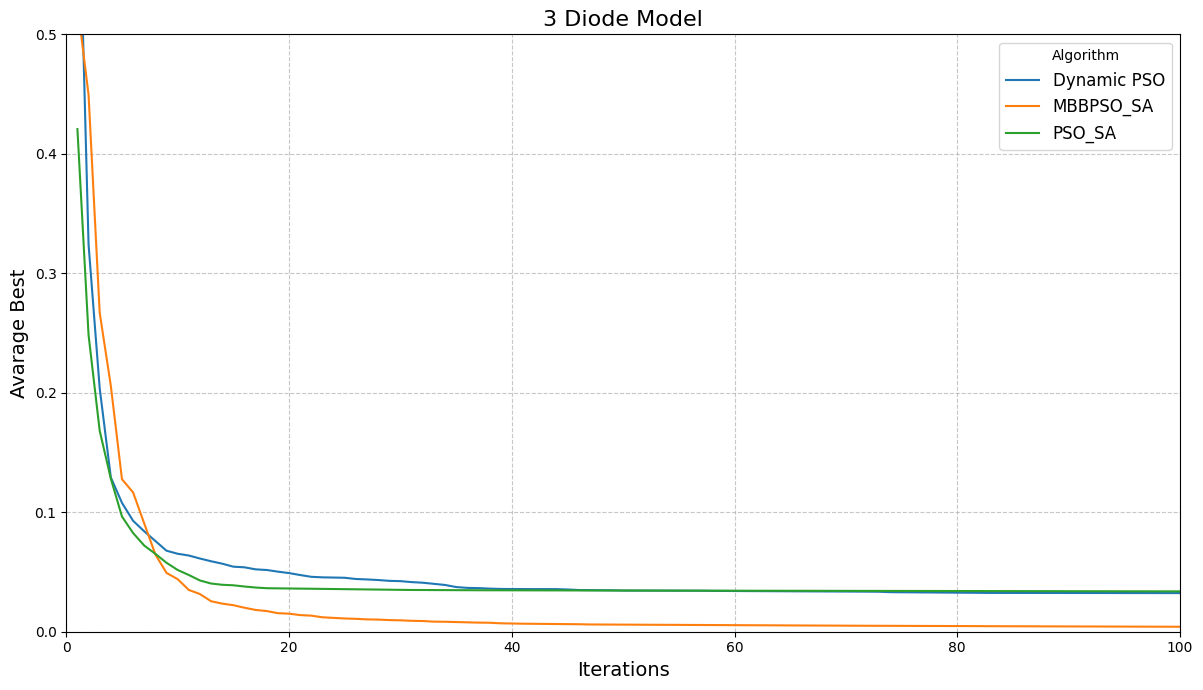

In [35]:
mean_fgbest_results = df_records.groupby('Algorithm')['fgbest_arr'].apply(lambda x: np.mean(np.stack(x), axis=0))

plt.figure(figsize=(12, 7)) 

for algorithm, mean_arr in mean_fgbest_results.items():
    if algorithm != "DE" and algorithm != "SA":
        x_axis = np.arange(1, len(mean_arr) + 1)
        plt.plot(x_axis, mean_arr, label=algorithm)

plt.title(f'{diode_model_type} Diode Model', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Avarage Best', fontsize=14)
plt.legend(title='Algorithm', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

#plt.xlim(0, 100)
#plt.ylim(0.00, 0.5)


### Wilcoxon Test Result

In [14]:
pivot_df = df_records.pivot(index='Seed', columns='Algorithm', values='Best Fitness')

baselines = ['MBBPSO_SA', 'PSO_SA', 'Dynamic PSO']
all_algos = list(pivot_df.columns)

for base in baselines:
    print(f"\n--- Wilcoxon Signed-Rank Test Results for Baseline: {base} ---")
    print("-" * 60)
    
    print(f"{'Comparison':<30} {'R+':>8} {'R-':>8} {'p-value':>12}")
    print("-" * 60)
    
    rows = []
    for other in all_algos:
        if base == other:
            continue
        
        paired = pivot_df[[base, other]].dropna()
        
        if len(paired) < 2: 
            continue
        
        diff = paired[other] - paired[base]
        
        if diff.abs().sum() == 0:
            R_plus, R_minus, p_value = 0, 0, 1.0
        else:
            try:
                stat, p_value = wilcoxon(diff, zero_method='pratt')
                
                ranked_diff = diff.abs().rank()
                
                R_plus = ranked_diff[diff > 0].sum()
                R_minus = ranked_diff[diff < 0].sum()
            except ValueError:
                R_plus, R_minus, p_value = float('nan'), float('nan'), float('nan')
        
        r_plus_str = str(int(R_plus)) if not pd.isna(R_plus) else '-'
        r_minus_str = str(int(R_minus)) if not pd.isna(R_minus) else '-'
        p_value_str = f"{p_value:.4E}" if not pd.isna(p_value) else '-'
        
        rows.append((f"{base} vs {other}", r_plus_str, r_minus_str, p_value_str))

    for row in rows:
        print(f"{row[0]:<30} {row[1]:>8} {row[2]:>8} {row[3]:>12}")
    
    print("-" * 60)
    print("\n")


--- Wilcoxon Signed-Rank Test Results for Baseline: MBBPSO_SA ---
------------------------------------------------------------
Comparison                           R+       R-      p-value
------------------------------------------------------------
MBBPSO_SA vs BBPSO                    5       10   6.2500E-01
MBBPSO_SA vs DE                      15        0   6.2500E-02
MBBPSO_SA vs Dynamic PSO             15        0   6.2500E-02
MBBPSO_SA vs MBBPSO                   5       10   6.2500E-01
MBBPSO_SA vs PSO                     13        2   1.8750E-01
MBBPSO_SA vs PSO_SA                  14        1   1.2500E-01
MBBPSO_SA vs SA                      15        0   6.2500E-02
------------------------------------------------------------



--- Wilcoxon Signed-Rank Test Results for Baseline: PSO_SA ---
------------------------------------------------------------
Comparison                           R+       R-      p-value
------------------------------------------------------------
PSO_

### Find Mean, Std, Time, Best Fitnes, Ranks 

In [15]:
algorithm_stats = df_records.groupby('Algorithm')['Best Fitness'].agg(['mean', 'std'])
algorithm_stats["Mean Time (sec)"] = df_records.groupby('Algorithm')['Time (s)'].agg(['mean'])
algorithm_stats["Best Fitness Value"] = df_records.groupby('Algorithm')['Best Fitness'].min()
algorithm_stats = algorithm_stats.sort_values(by='mean', ascending=True)

algorithm_stats['Rank'] = np.arange(1, len(algorithm_stats) + 1)

print(algorithm_stats)

                 mean       std  Mean Time (sec)  Best Fitness Value  Rank
Algorithm                                                                 
BBPSO        0.001719  0.002165        15.932814            0.000434     1
MBBPSO       0.002421  0.001386        15.985270            0.000997     2
MBBPSO_SA    0.002745  0.000950        17.292974            0.001812     3
DE           0.004732  0.000837        18.538101            0.003642     4
SA           0.036621  0.008864         1.014863            0.024551     5
PSO          0.047850  0.083710        17.993070            0.000469     6
PSO_SA       0.086340  0.100564        17.446236            0.000427     7
Dynamic PSO  0.093736  0.092526        16.752949            0.003501     8
